In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train_sat6.csv', 'sat6annotations.csv', 'sat-6-full.mat', 'y_test_sat6.csv', 'X_train_sat6.csv', 'X_test_sat6.csv']


In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
#The dataset is too large, we only use a small part of it
nrows_train = 20000
nrows_test = 5000
X_train = pd.read_csv('../input/X_train_sat6.csv', 
                      nrows=nrows_train, 
                      header=None).values.reshape(-1, 28, 28, 4)
y_train = pd.read_csv('../input/y_train_sat6.csv', 
                     nrows=nrows_train, 
                      header=None).values
X_test = pd.read_csv('../input/X_test_sat6.csv', 
                      nrows=nrows_test, 
                      header=None).values.reshape(-1, 28, 28, 4)
y_test = pd.read_csv('../input/y_test_sat6.csv', 
                     nrows=nrows_test, 
                      header=None).values

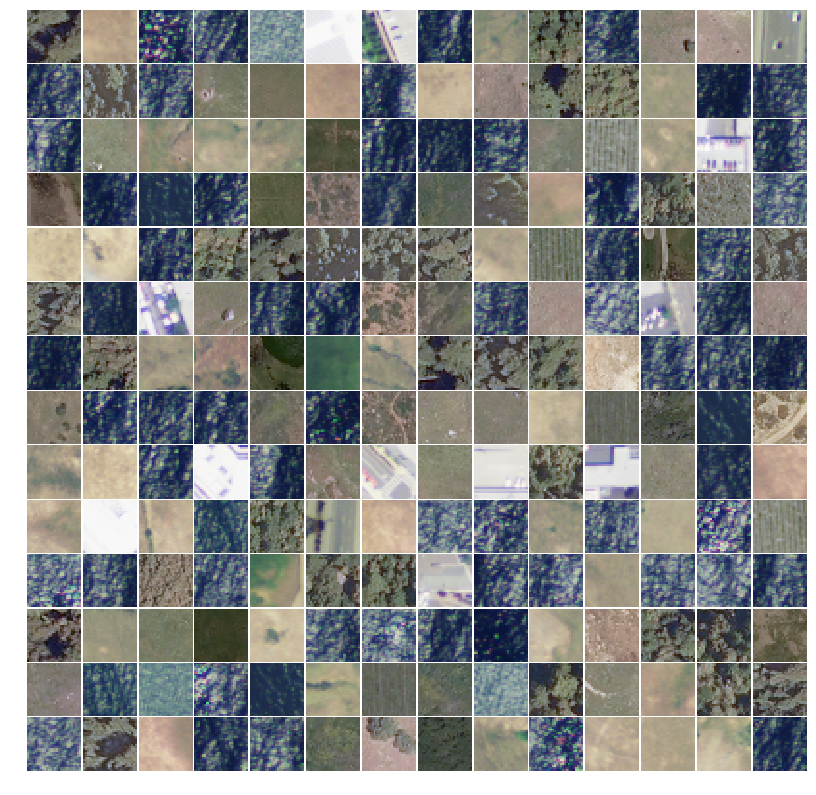

In [4]:
fig, m_axs = plt.subplots(14, 14, figsize = (14, 14))
plt.subplots_adjust(wspace =0.01, hspace =0.02)
for (x, y, c_ax) in zip(X_train[:14*14], y_train[:14*14], m_axs.flatten()):
    c_ax.imshow(x[:,:,:3], # since we don't want NIR in the display
                interpolation = 'none')
    c_ax.axis('off')
    #c_ax.set_title('Class:{}'.format(y))
plt.show()

In [5]:
X_train.shape, y_train.shape

((20000, 28, 28, 4), (20000, 6))

In [6]:
np.min(X_train), np.max(X_train)

(0, 255)

## The above X_train range indicates that we should do normalisation.

In [7]:
#creating the model
input_layer = Input(shape=(28,28,4), name='input')
x = Conv2D(32,3,activation='relu',padding='same', name='conv1')(input_layer)
x = MaxPool2D(pool_size=(2,2), name='maxpool1')(x)
#x = Dropout(0.2)(x)
x = Conv2D(64,3,activation='relu',padding='same', name='conv2')(x)
x = MaxPool2D(pool_size=(2,2), name='maxpool2')(x)
x = Flatten(name='flatten')(x)
x = Dense(128, activation='relu',use_bias=False,name='fc')(x)
#x = Dropout(0.2)(x)
x = Dense(6,activation='softmax',name='output')(x)
model = Model(inputs=input_layer, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 4)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        1184      
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
fc (Dense)                   (None, 128)               401408    
__________

In [8]:
# Setting up optimizer
base_lr = 0.01
momentum = 0.9
batch_size = 128
optimizer = SGD(lr=base_lr, 
                momentum=momentum, 
                decay=0.0005, 
                nesterov=True)

#compiling
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
epochs = 20 #May be more
model.fit(x = X_train/255., y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1)


Train on 18000 samples, validate on 2000 samples
Epoch 1/20
18000/18000 [==============================] - 8s 438us/step - loss: 0.5213 - acc: 0.7953 - val_loss: 0.2350 - val_acc: 0.9040
Epoch 2/20
18000/18000 [==============================] - 3s 190us/step - loss: 0.2041 - acc: 0.9195 - val_loss: 0.1677 - val_acc: 0.9330
Epoch 3/20
18000/18000 [==============================] - 3s 192us/step - loss: 0.1448 - acc: 0.9448 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 4/20
18000/18000 [==============================] - 3s 190us/step - loss: 0.1175 - acc: 0.9569 - val_loss: 0.1285 - val_acc: 0.9460
Epoch 5/20
18000/18000 [==============================] - 3s 191us/step - loss: 0.1051 - acc: 0.9604 - val_loss: 0.1036 - val_acc: 0.9655
Epoch 6/20
18000/18000 [==============================] - 3s 191us/step - loss: 0.0967 - acc: 0.9642 - val_loss: 0.1469 - val_acc: 0.9435
Epoch 7/20
18000/18000 [==============================] - 3s 190us/step - loss: 0.0893 - acc: 0.9678 - val_loss: 0.1022 - v

In [10]:
# testing
test_loss,test_acc =model.evaluate(x=X_test/255., y=y_test, batch_size=100)

print("Test acc: %.2f%%" % (test_acc*100))

5000/5000 [==============================] - 0s 91us/step
Test acc: 97.56%


             precision    recall  f1-score   support

          0       0.95      0.99      0.97       223
          1       0.99      0.94      0.97      1163
          2       0.98      0.99      0.98       925
          3       0.90      0.97      0.93       773
          4       0.99      0.85      0.92       116
          5       1.00      1.00      1.00      1800

avg / total       0.98      0.98      0.98      5000

Overall Accuracy: 97.56%

Confusion matrix: 
 [[ 221    0    0    0    1    1]
 [   0 1095    2   66    0    0]
 [   0    0  917    8    0    0]
 [   0    8   19  746    0    0]
 [  11    0    1    5   99    0]
 [   0    0    0    0    0 1800]]


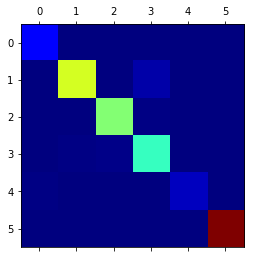

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test_pred = model.predict(X_test/255.)
print(classification_report(np.argmax(y_test, 1), np.argmax(y_test_pred, 1)))
print('Overall Accuracy: %2.2f%%' % (100*accuracy_score(np.argmax(y_test, 1), np.argmax(y_test_pred, 1))))
print('\nConfusion matrix: \n', confusion_matrix(np.argmax(y_test, 1), np.argmax(y_test_pred, 1)))
plt.matshow(confusion_matrix(np.argmax(y_test, 1), np.argmax(y_test_pred, 1)), cmap='jet')

In [12]:
X_test_all = pd.read_csv('../input/X_test_sat6.csv', 
                      header=None).values.reshape(-1, 28, 28, 4)
y_test_all = pd.read_csv('../input/y_test_sat6.csv', 
                      header=None).values

# Prediction results on all test data

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      3714
          1       0.99      0.94      0.96     18367
          2       0.97      0.99      0.98     14185
          3       0.91      0.96      0.93     12596
          4       0.99      0.84      0.91      2070
          5       1.00      1.00      1.00     30068

avg / total       0.98      0.97      0.97     81000

Overall Accuracy: 97.46%

Confusion matrix: 
 [[ 3687     0     2     0    22     3]
 [    2 17238    28  1097     2     0]
 [    0     2 14098    85     0     0]
 [    0   121   355 12118     2     0]
 [  227     3     8    73  1736    23]
 [    0     0     0     0     0 30068]]


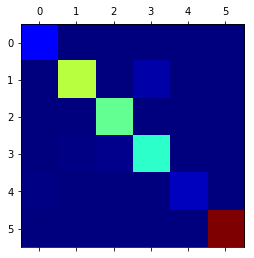

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test_all_pred = model.predict(X_test_all/255.)
print(classification_report(np.argmax(y_test_all, 1), np.argmax(y_test_all_pred, 1)))
print('Overall Accuracy: %2.2f%%' % (100*accuracy_score(np.argmax(y_test_all, 1), np.argmax(y_test_all_pred, 1))))
print('\nConfusion matrix: \n', confusion_matrix(np.argmax(y_test_all, 1), np.argmax(y_test_all_pred, 1)))
plt.matshow(confusion_matrix(np.argmax(y_test_all, 1), np.argmax(y_test_all_pred, 1)), cmap='jet')